In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten


from PIL import Image
from io import BytesIO
import base64
from IPython.core.display import display, HTML

C:\Users\angga\AppData\Local\Temp\ipykernel_35620\3331521539.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available.")
    # Additional information about the GPUs
    for gpu in gpu_available:
        print(tf.config.experimental.get_device_details(gpu))
else:
    print("GPU is not available.")

GPU is available.
{'device_name': 'NVIDIA GeForce RTX 2060', 'compute_capability': (7, 5)}


In [3]:
BASIC_PATH = "./dataset/"
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba/') # PURE IMAGE
LIST_ATTR_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv') # Fiture Male

DF_ATTR = pd.read_csv(BASIC_PATH + 'list_attr_celeba.csv', delimiter=',')
print(IMG_PATH, LIST_ATTR_PATH)
DF_ATTR.head()

./dataset/img_align_celeba/img_align_celeba/ ./dataset/list_attr_celeba.csv


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [4]:
DF_PARTITION = pd.read_csv(BASIC_PATH + 'list_eval_partition.csv') # Attribut  -> Gambar


In [5]:
DF_ATTR.set_index('image_id', inplace=True)
DF_ATTR.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
DF_ATTR.shape

(202599, 40)

In [6]:
DF_PARTITION['partition'].value_counts().sort_index() 

partition
0    162770
1     19867
2     19962
Name: count, dtype: int64

In [7]:
# join the partition with the attributes
DF_PARTITION.set_index('image_id', inplace=True)
DF_PARTITION = DF_PARTITION.join(DF_ATTR['Male'], how='inner')
DF_PARTITION.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [8]:
#ATTRIBUTES

# Read the attributes csv files in a dataframe format.
df = pd.read_csv(LIST_ATTR_PATH, usecols=['image_id','Male'])
df = df.sample(n=2500, random_state = 42).reset_index(drop=True)

# Reset the columns values to categorical./
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

# Change column names.
df.columns = ["image_id", "Gender"]

df.head(-10)

,image_id,Gender
0,093242.jpg,Male
1,121414.jpg,Female
2,010625.jpg,Male
3,082524.jpg,Female
4,073193.jpg,Female
...,...,...
2485,181963.jpg,Female
2486,156956.jpg,Female
2487,092708.jpg,Male
2488,039176.jpg,Female


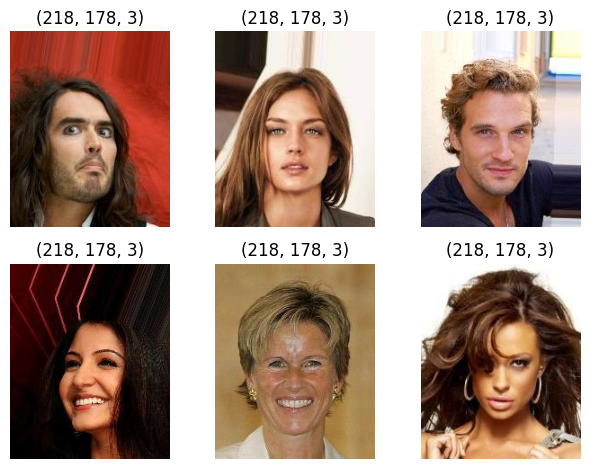

In [9]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    
    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# ( 160,160.3)

In [10]:
# Get the category distribution.
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

Gender
Female    1442
Male      1058
Name: count, dtype: int64


In [11]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

<Axes: xlabel='Gender'>

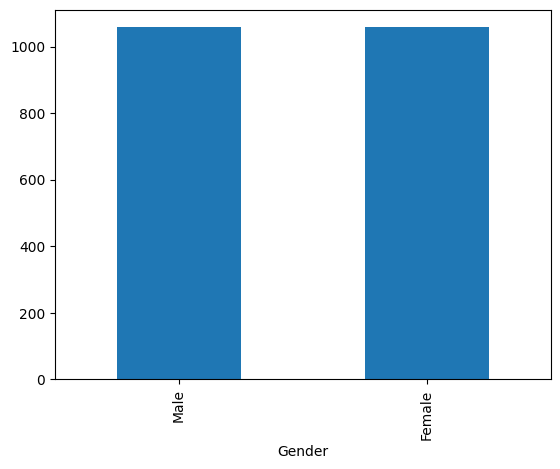

In [12]:
df["Gender"].value_counts().plot.bar()

In [13]:
train_df, test_df = train_test_split(df, test_size=0.2)
test_df, validation_df = train_test_split(test_df, test_size=0.33)

In [14]:
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))
print("Total Validation Sample Images : ", len(validation_df))

Total Train Sample Images :  1692
Total Test Sample Images :  284
Total Validation Sample Images :  140


In [15]:
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 32
VERBOSSE = 10


In [16]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    IMG_PATH + "/", 
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1692 validated image filenames belonging to 2 classes.


In [17]:
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    IMG_PATH + "/", 
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 140 validated image filenames belonging to 2 classes.


In [18]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    IMG_PATH + "/",  
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 284 validated image filenames.


GAPERLU

In [19]:
'''train_dataset = tf.data.Dataset.from_generator(lambda:train_generator, 
                                               output_signature=(tf.TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(None, 2), dtype=tf.float32)))

validation_dataset = tf.data.Dataset.from_generator(lambda:validation_generator, 
                                               output_signature=(tf.TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(None, 2), dtype=tf.float32)))


test_dataset = tf.data.Dataset.from_generator(lambda:test_generator, 
                                               output_signature=(tf.TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(None, 2), dtype=tf.float32)))'''



'train_dataset = tf.data.Dataset.from_generator(lambda:train_generator, \n                                               output_signature=(tf.TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32),\n                                                                tf.TensorSpec(shape=(None, 2), dtype=tf.float32)))\n\nvalidation_dataset = tf.data.Dataset.from_generator(lambda:validation_generator, \n                                               output_signature=(tf.TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32),\n                                                                tf.TensorSpec(shape=(None, 2), dtype=tf.float32)))\n\n\ntest_dataset = tf.data.Dataset.from_generator(lambda:test_generator, \n                                               output_signature=(tf.TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32),\n                                                                tf.TensorSpec(shape=(None, 2), dtype=tf.float32)))'

In [31]:
base_model = tf.keras.applications.VGG16(weights='imagenet', 
                                                include_top=False, 
                                                   input_shape= IMAGE_SIZE + (3,))

In [32]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

BASE MODEL

In [33]:
model = Sequential(
    [
    base_model, #mobilenet
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
]
)

x = base_model.output
predictions = Dense(2, activation='sigmoid') (x)

In [34]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 15360)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               3932416   
                                                                 
 dense_15 (Dense)            (None, 256)               65792     
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 32)               

In [35]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', # load
                               verbose=1, save_best_only=True)

In [37]:
#param tuning?
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

callbacks = [earlystop, learning_rate_reduction, checkpointer]

In [38]:
history = model.fit(train_generator, validation_data = validation_generator
                        , validation_steps=len(validation_df)//BATCH_SIZE
                        ,steps_per_epoch=len(train_df)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=callbacks)

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.5255 - accuracy: 0.7114
Epoch 1: val_loss improved from inf to 0.42112, saving model to weights.best.inc.male.hdf5
52/52 [==============================] - 28s 409ms/step - loss: 0.5255 - accuracy: 0.7114 - val_loss: 0.4211 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 2/10
52/52 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.8506
Epoch 2: val_loss improved from 0.42112 to 0.36932, saving model to weights.best.inc.male.hdf5
52/52 [==============================] - 16s 305ms/step - loss: 0.3462 - accuracy: 0.8506 - val_loss: 0.3693 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.8922
Epoch 3: val_loss improved from 0.36932 to 0.31531, saving model to weights.best.inc.male.hdf5
52/52 [==============================] - 16s 311ms/step - loss: 0.2737 - accuracy: 0.8922 - val_loss: 0.3153 - val_accuracy: 0.8594 - lr: 0.0010
Ep

history = model.fit(train_generator, validation_data = validation_generator
                        , validation_steps=len(validation_df)//BATCH_SIZE
                        ,steps_per_epoch=len(train_df)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=callbacks)

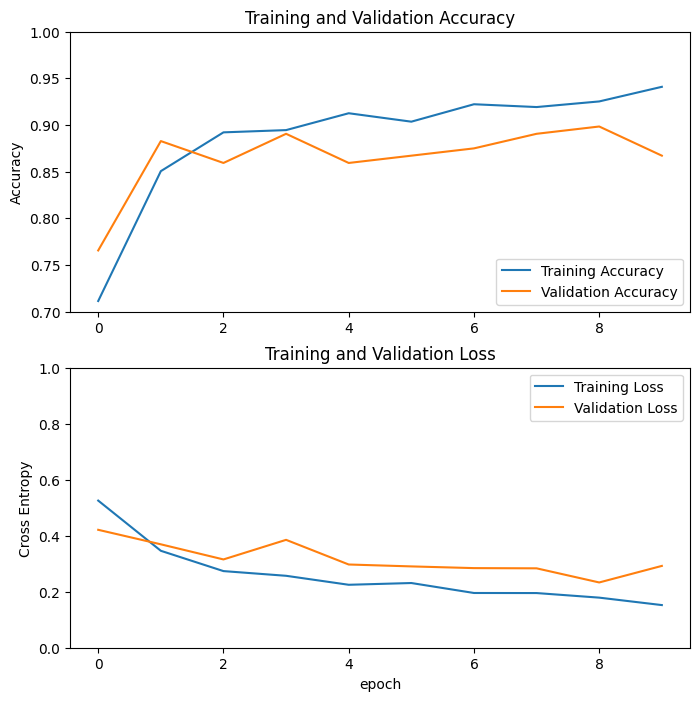

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
base_learning_rate = 0.0001

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 53760)             0         
                                                                 
 dense (Dense)               (None, 256)               13762816  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                        

In [ ]:
len(model.trainable_variables)

66

In [ ]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

Epoch 10/20


c:\Users\angga\.conda\envs\tf.2.10\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


106/106 [==============================] - 18s 124ms/step - loss: 0.8851 - accuracy: 0.8215 - val_loss: 0.3065 - val_accuracy: 0.9000
Epoch 11/20
106/106 [==============================] - 12s 115ms/step - loss: 0.4081 - accuracy: 0.8842 - val_loss: 0.2625 - val_accuracy: 0.9214
Epoch 12/20
106/106 [==============================] - 13s 122ms/step - loss: 0.3070 - accuracy: 0.8871 - val_loss: 0.2489 - val_accuracy: 0.9071
Epoch 13/20
106/106 [==============================] - 13s 118ms/step - loss: 0.2463 - accuracy: 0.9090 - val_loss: 0.2428 - val_accuracy: 0.9214
Epoch 14/20
106/106 [==============================] - 12s 117ms/step - loss: 0.2322 - accuracy: 0.9173 - val_loss: 0.2035 - val_accuracy: 0.9286
Epoch 15/20
106/106 [==============================] - 12s 114ms/step - loss: 0.2042 - accuracy: 0.9243 - val_loss: 0.1928 - val_accuracy: 0.9357
Epoch 16/20
106/106 [==============================] - 12s 117ms/step - loss: 0.1925 - accuracy: 0.9208 - val_loss: 0.1925 - val_accurac

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

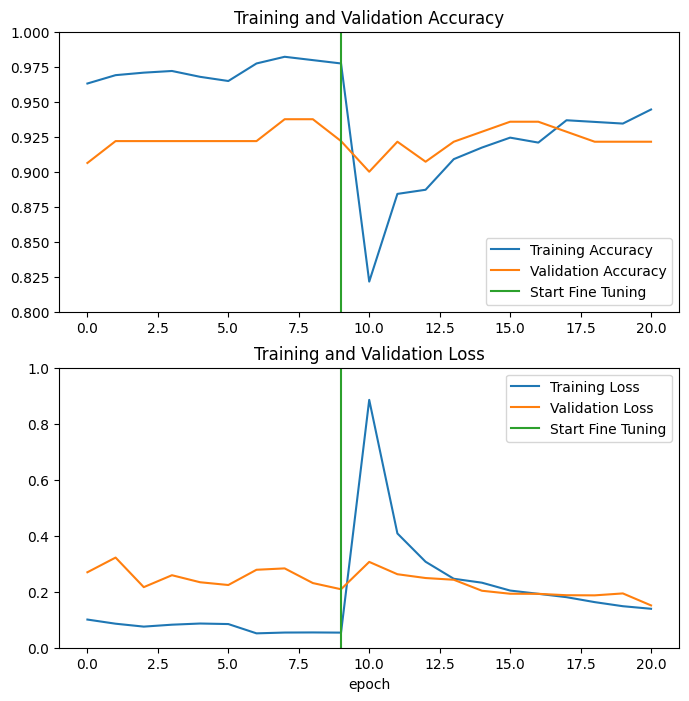

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
model.load_weights('weights.best.inc.male.hdf5')

In [41]:
predict = model.predict(test_generator, steps=np.ceil(len(test_df)/BATCH_SIZE))

9/9 [==============================] - 2s 114ms/step


In [42]:
prediction = predict.argmax(axis=-1)
test_df['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]

In [43]:
test_df

,image_id,Gender,Prediction
119,071160.jpg,Female,Female
2406,162337.jpg,Female,Female
914,060475.jpg,Male,Male
1230,102227.jpg,Male,Male
976,148106.jpg,Male,Male
...,...,...,...
1461,107642.jpg,Female,Female
780,187640.jpg,Male,Male
612,152534.jpg,Male,Female
2334,140047.jpg,Male,Male


In [44]:
labels = ['Male','Female']

cm = confusion_matrix(test_df['Gender'], test_df["Prediction"], labels= labels)
cm

array([[123,  13],
       [ 11, 137]], dtype=int64)

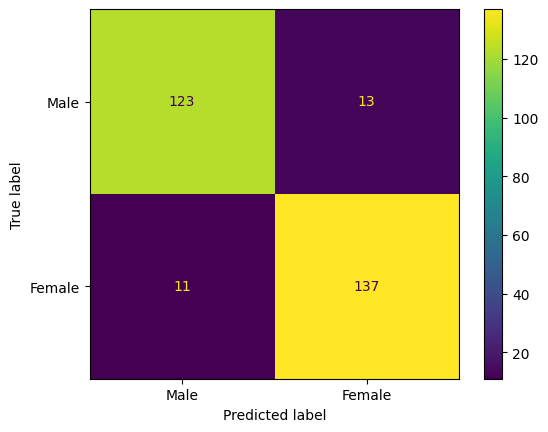

In [49]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

In [50]:
print(classification_report(test_df['Gender'], test_df["Prediction"], labels= labels))

              precision    recall  f1-score   support

        Male       0.92      0.90      0.91       136
      Female       0.91      0.93      0.92       148

    accuracy                           0.92       284
   macro avg       0.92      0.92      0.92       284
weighted avg       0.92      0.92      0.92       284



1/1 [==============================] - 0s 33ms/step
[3.4278157e-01 5.2378947e-08]
This is a male


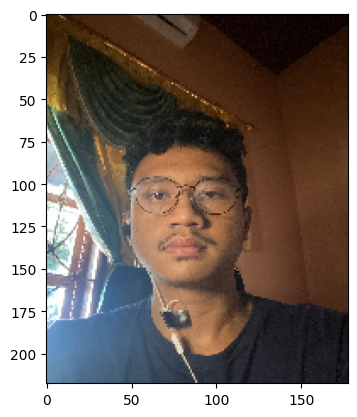

In [51]:
import numpy as np

import keras.utils as image
#  images test 1
#path_testmodel = '/content/testmodel/test5.jpg'
path_testmodel= "foto.jpg"
imge = image.load_img(path_testmodel, target_size=IMAGE_SIZE)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes.all()>0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

1/1 [==============================] - 0s 27ms/step
[1. 0.]
This  is a female


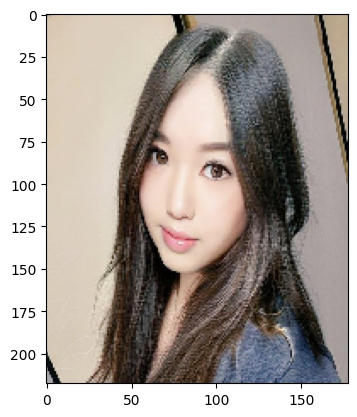

In [59]:
import numpy as np

import keras.utils as image
#  images test 1
#path_testmodel = '/content/testmodel/test5.jpg'
path_testmodel= "foto1.jpeg"
imge = image.load_img(path_testmodel, target_size=IMAGE_SIZE)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes.all()>0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

In [ ]:
import numpy as np

import keras.utils as image
#  images test 1
#path_testmodel = '/content/testmodel/test5.jpg'
path_testmodel= "foto.jpg"
imge = image.load_img(path_testmodel, target_size=IMAGE_SIZE)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes.all()>0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

In [31]:
gender_target = {0: 'Female', 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [32]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model.predict(im)
    prediction = np.argmax(result)
    
    return result

1/1 [==============================] - 1s 599ms/step



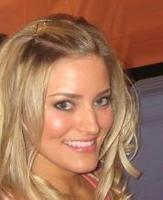

1/1 [==============================] - 0s 29ms/step



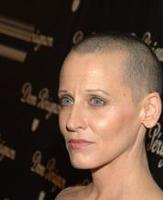

1/1 [==============================] - 0s 29ms/step



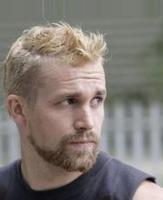

1/1 [==============================] - 0s 23ms/step



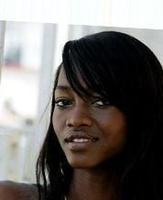

1/1 [==============================] - 0s 26ms/step



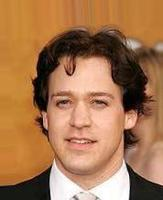

1/1 [==============================] - 0s 31ms/step



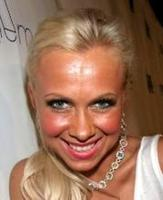

1/1 [==============================] - 0s 27ms/step



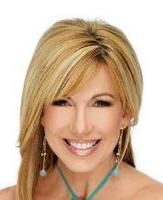

1/1 [==============================] - 0s 38ms/step



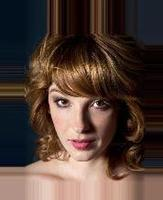

In [33]:
df_to_test = DF_PARTITION[(DF_PARTITION['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(IMG_PATH + index)
    
    #display result
    display_result(IMG_PATH + index, result[0], target['Male'])